In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
# exploring the mnist dataset

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

Each image is 28x28 matrix and each feature represenst the pixel's intensity ranging from 0 (white) to 255 (black).  

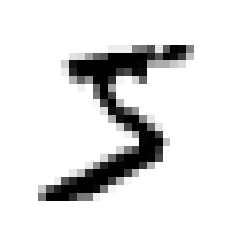

In [ ]:
# view and example image
# there are differences with how pandas and numpy behave in the versions on EMR and those on my system
# for example, the code below, I need the line with iloc to slice the row for the image below

import matplotlib as mpl
import matplotlib.pyplot as plt

# some_digit = X[0]
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
# the label is a string, so we need to convert to an int
import numpy as np
y = y.astype(np.uint8)

In [ ]:
# the mnist data is already split into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train a Binary Classifier

In [ ]:
# train a binary classifier

# setup
y_train_5 = (y_train == 5) # setting up binary target == 5
y_test_5 = (y_test == 5)

# train the stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)


SGDClassifier()

In [ ]:
# predict with the trained classifier
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([False])

## Model Performance Evaluation

### Common Options

* Accuracy with Cross-Validation
Implementing a custom version with more flexibility than the one shipped with scikit-learn is not complicated.... see below.


In [ ]:
# custom cross-validation

# Dependencies
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

""" newer versions of pandas """
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5.iloc[test_index]


""" for use on EMR system
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
"""

# Use clone ultility to fit folds and aggregrate results
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))



0.96845
0.96685
0.9663


In [ ]:
# cross-validation with shipped methdo from scikit-learn
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.959     , 0.96166667, 0.94558333, 0.95516667, 0.96275   ])

While the accuracies look great, this is an example of an imbalanced classifier.  Therefore we need to examine it with a better metrics to evaluation the model.  To show this, the next code shows a naive classification model that just classifies all images as "not-5".

In [ ]:
# showing issues of class imbalance
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self

  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)


In [ ]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

Inspect the distribution of the predicted labels.

In [ ]:
# setup dependencies for the confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
# evaluate the confustion matric
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53896,   683],
       [ 1627,  3794]])

### Metrics from the Confusion Matrix

* Precision = accuracy of true positives

TP / TP + FP, e.g.) how many actual TPs do we have out of the to total count of positive instances - 5's in this case, whether they are TP or FP (negative instances classified to postives)

Precision alone can also be misleading since the denominator is composed only of the available positive cases.  If all positive cases are predicted accurately then a 100% precision will result. We need another measure to help

* Recall | Sensitivity | TPR  

The recall is how sensitive the classifier is since it incorporates the FN in labes in the denominator.
TP / TP + FN, where FN represents the postive class falsely classified as a negative...e.g.so "sensitivity".

In [ ]:
# metrics from the confusion matrix
# Precision = accuracy of true positives

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8474424838061202
0.699870872532743


The interpretation of the precision and recall metrics is important and provides a richer understanding of a classifier's performance.  For example, the precision = 0.80 which means that when the model claims an image is a 5 it is correct 80% of the time.  The recall is a nice compliment to the precision since in this case it shows that the model only detects 5's 72.4% of the time...only so-s0 sentivity.

### Combining Precision and Recall: F1

The F1 score is the harmonic mean of the precision and recall.  The harmonic mean calculated in such a way that that lower values get more weight.  This ensures that the a larger F1 score is driven by *both* the precision and recall being large.

F1 = 2/(1/precision + 1/recall) = 2 * (precision*recall)/(precision + recall) = TP/(TP + (FN + FP)/2)

In [ ]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7666195190947666

F1 favors the case when precision and recall for more balanced.  This may not always be the goal of the prediction.  For example, when we need to classify only good examples to be presented to a review team, we will favor high precision, but low recall (sensitivity).  On the other hand, one might want to ensure the model is very sensitive to alert or warn on events like possible shop-lifting.  In that case, we may favor a highly senstive model (recall) with lower precision.  There may be some FPs that need to be dealt with downstream.

The scores from a classifier can be used to set the threshold a decision function used in the classififer to achieve a different balance of recall and precision depending on the need of the stakeholder

In [ ]:
# adjusting the decision threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([-2255.19919695])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [ ]:
y_scores.min()

-2255.199196952

In [ ]:
# increse the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The image in `some_digit` actually represents a "5" so this shows how raising the threshold decreases recall (sensitivity) of the classifier.

### How to specify threshold

In [ ]:
# specifying threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = "decision_function")

With all the raw scores from the decision function we can use them to plot a curve of precision and recall versus all the available thresholds.

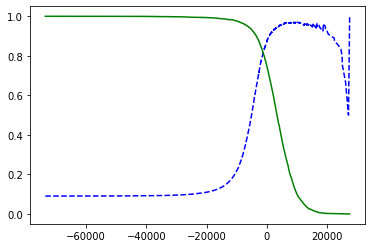

In [ ]:
# precision recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# matplotlib to plot the results
def plot_precision_recall(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  [...]

plot_precision_recall(precisions, recalls, thresholds)
plt.show()

In [ ]:
                                                                                           # so, how to find the optimal threshold?
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

722.081417292088

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90 == True


array([ True, False, False, ...,  True, False, False])

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9001186239620403

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.699870872532743

## ROC Curve

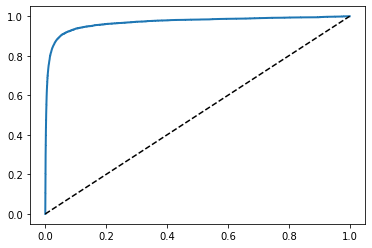

In [ ]:
# construct a ROC curve
from sklearn.metrics import roc_curve

# grab the data needed
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# define the plot function
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')  # dashed diagonal
  [...]  # add axis labels and grid, etc.

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9687614296387457

Assess SGD Classifier aginst Random Forest Classifier

In [ ]:
# Random Forest

# import -----
from sklearn.ensemble import RandomForestClassifier

# train -----
forest_clf = RandomForestClassifier(random_state = 42)
y_proba_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv = 3,
    method = "predict_proba"
)

In [ ]:
# grab the postive class probas for roc_curve

# get data -----
y_scores_forest = y_proba_forest[:,1] # score = prob pos class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


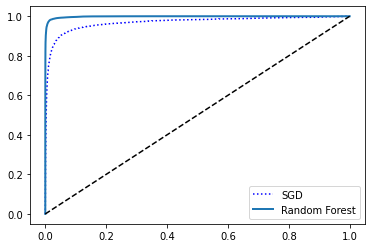

In [ ]:
# roc_curve comparing SGD and Random Forests

# plot -----
plt.plot(fpr, tpr, "b:",  label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# compute the Random Forest AUC score
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
# get the 90% precision threshold -----
forest_thresh_90prec = thresholds_forest[np.argmax(tpr_forest >= 0.90)]

# calc binary pred response -----
y_forest_binary = (y_scores >= forest_thresh_90prec)

# precision and recall scores
print(precision_score(y_train_5, y_forest_binary))
print(recall_score(y_train_5, y_forest_binary))

0.8755960121369745
0.7452499538830474


## Moving on multi-class evaluation

In [ ]:
# SVC Classifier using the OvO strategy

# import -----
from sklearn.svm import SVC

# train -----
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=uint8)

In [ ]:
# seeing the outcome of the OvO scoring and choice
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
# forcing the classifier to use OvR strategy

# imports -----
from sklearn.multiclass import OneVsRestClassifier

# train -----
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

# predict -----
ovr_clf.predict([some_digit])

In [52]:
# ease of prediction multiple classed with other models like
# SGD or Random Forests

# using SGD to follow the book -----
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=uint8)

In [56]:
print(sgd_clf.decision_function([some_digit]))
print(np.argmax(sgd_clf.decision_function([some_digit])))

[[-17862.78005237 -36578.63753762 -13862.97980556   -554.3313865
  -19907.09995809   5222.10809526 -27432.82379877 -17045.42904684
  -15278.13936407 -12304.68371234]]
5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [58]:
# model performance with cross-validation
cross_val_score(
    sgd_clf, 
    X_train, 
    y_train, 
    cv = 3, 
    scoring = "accuracy"
    )

array([0.8708, 0.8779, 0.8745])

In [ ]:
# some improvement with scaling the imput intensities
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(
    sgd_clf,
    X_train_scaled,
    y_train,
    cv = 3, 
    scoring = "accuracy"
)


## Error Analysis

Once a model is buitt that will satisfy the requirements, to make further improvements on that model it's often beneficial to undergo some error analysis to identify the types of errors being produced and and how we might go ahead fixing them.

In [ ]:
y_train_pred = cross_val_predicted(sgd_clf, X_train)